# Generative Adversial Model

The goal is to generate new articles from Zalando.

We follow this tutorial: https://www.tensorflow.org/tutorials/generative/dcgan

# Load data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist

from matplotlib import pyplot as plt

In [ ]:
# From Google Drive with Colaboratory

from google.colab import drive
import os

drive.mount('/content/gdrive')
folder = "/content/gdrive/MyDrive"
os.listdir(folder)

Mounted at /content/gdrive


['datasets', 'Colab Notebooks', 'models']

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(y_train.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)


In [ ]:
print(28*28)
print(14*14)
print(7*7)

784
196
49


# Create the generator

* To generate new images each time, we need a seed. We decide our seed of randoms numbers will be a vector of length 100.
* We use `Conv2DTranspose` to upsample our image (making it 2x bigger). We want to output a (28, 28) image: so we need to go from (7,7) to (14,14) to (28,28), needing 3 blocks of upsampling.
* `BatchNormalization` normalize the input. It stabilize the training process, useful for any DCNN (Deep Convolutional Neural Networks).
* We use `LeakyReLu` for activation (ReLu works too, but can lead to vanishing gradients)
* `tanh` is used as the activation function of the last layer because we want our image centered in the range [-1, 1] 

In [ ]:
noise_dim = 100
kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

generator = keras.models.Sequential([
  # 1 dimensional vector
  keras.layers.Dense(7 * 7 * 256, input_dim=noise_dim),
  keras.layers.BatchNormalization(),
  keras.layers.LeakyReLU(),

  # 3 dimensional vector of shape 7*7
  keras.layers.Reshape((7, 7, 256)),
  keras.layers.Conv2DTranspose(128, (5, 5), 
                               strides=(2, 2), padding="same",
                               kernel_initializer=kernel_initializer),
  keras.layers.BatchNormalization(),
  keras.layers.LeakyReLU(),

  # 3 dimensional vector of shape 14*14
  keras.layers.Conv2DTranspose(64, (5, 5), 
                            strides=(2, 2), padding="same",
                            kernel_initializer=kernel_initializer),
  keras.layers.BatchNormalization(),
  keras.layers.LeakyReLU(),

  # 3 dimensional vector of shape 28*28
  keras.layers.Conv2D(1, (5, 5), padding="same", activation="tanh")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      5

(1, 28, 28, 1)
(28, 28)


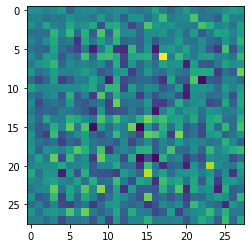

In [ ]:
# Try the generator (untrained)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
img = generated_image[0, :, :, 0]
print(img.shape)
plt.imshow(img)

# Create the discriminator

In [ ]:
input_shape = (28, 28, 1)

discriminator = keras.models.Sequential([
  # block 1
  keras.layers.Conv2D(64, (5, 5), 
                      strides=(2, 2), padding="same", 
                      input_shape=input_shape),
  keras.layers.BatchNormalization(),
  keras.layers.LeakyReLU(alpha=0.2),

  # block 2
  keras.layers.Conv2D(128, (5, 5), 
                      strides=(2, 2), padding="same", 
                      input_shape=input_shape),
  keras.layers.BatchNormalization(),
  keras.layers.LeakyReLU(alpha=0.2),

  # Output
  keras.layers.Flatten(),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Try the discriminator (untrained)

discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5003652]], dtype=float32)>

## Compile models



We override the `train_step()` method of `Keras.Model` to define our own training steps.

We use `tf.GradientTape()` in order to custom our training loop, while still benefiting from the other features of `.fit()`.

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, noise_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_dim = noise_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # The annotation `tf.function` allows it to be compiled.
    @tf.function
    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.noise_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


## Use callbacks to monitor the GAN

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, noise_dim=100):
        self.num_img = num_img
        self.noise_dim = noise_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, noise_dim])

    def on_epoch_end(self, epoch, logs=None):
        # Save model & display generated images
        self.model.generator.save(folder + "/datasets/fashion_mnist_test.h5")

        # random_noise_vectors = tf.random.normal(shape=(self.num_img, self.noise_dim))
        # generated_images = self.model.generator(random_noise_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save(folder + "/datasets/fashion_mnist_test.h5")

# Train!

In [ ]:
dcgan = DCGAN(discriminator=discriminator, 
              generator=generator, 
              noise_dim=noise_dim)

lr = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

No saved model found
Epoch 1/5
1875/1875 [==============================] - ETA: 0s - d_loss: 0.0205 - g_loss: 3.0542WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


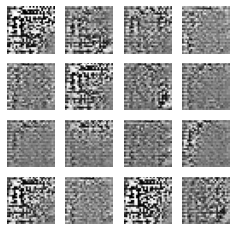

1875/1875 [==============================] - 1768s 943ms/step - d_loss: 0.0205 - g_loss: 3.0542
Epoch 2/5
1875/1875 [==============================] - ETA: 0s - d_loss: 7.6557e-04 - g_loss: 7.3801WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


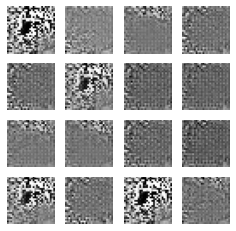

1875/1875 [==============================] - 1767s 942ms/step - d_loss: 7.6557e-04 - g_loss: 7.3801
Epoch 3/5
1875/1875 [==============================] - ETA: 0s - d_loss: 0.0167 - g_loss: 8.9949WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


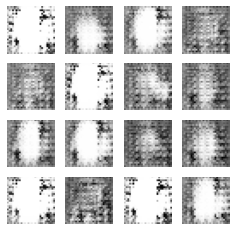

1875/1875 [==============================] - 1853s 988ms/step - d_loss: 0.0167 - g_loss: 8.9949
Epoch 4/5
1875/1875 [==============================] - ETA: 0s - d_loss: 0.0108 - g_loss: 6.5344WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


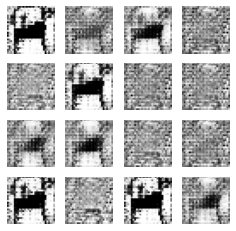

1875/1875 [==============================] - 1812s 966ms/step - d_loss: 0.0108 - g_loss: 6.5344
Epoch 5/5
1875/1875 [==============================] - ETA: 0s - d_loss: 3.3253e-04 - g_loss: 8.7118WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


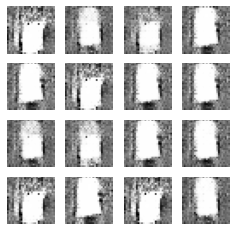

1875/1875 [==============================] - 1791s 955ms/step - d_loss: 3.3253e-04 - g_loss: 8.7118


In [ ]:
try:
  dcgan = keras.models.load_model(folder + "/datasets/fashion_mnist_test.h5")
except OSError:
  print("No saved model found")
  
dcgan.fit(X_train, epochs=5,
          callbacks=[GANMonitor(num_img=16, noise_dim=noise_dim)])

# How to improve?

* More training (epochs)
* According to https://arxiv.org/pdf/1905.05928, we should not place Batch Normalization before ReLU since the non- negative responses of ReLU will make the weight layer updated in a suboptimal way, and we can achieve better performance by combining Batch Normalization and Dropout together.
